### **saliency maps**

Saliency maps are heatmaps that highlight pixels in the input image that have the greatest influence on the output classification.A trained ConvNet for the problem of image classification would generate some class scores ( values in the output layer that the neural network assigns to classes before the softmax) , and we would get some output class for an input image based on the highest score.


Considering the gradient of the output class score with respect to the pixel values of the input image give us information about the imporatnce of pixel values. The pixels for which this gradient is large (either positive or negative) are the pixels that require the least amount of change to have the greatest impact on the class score. Such pixels are likely to correspond to the location of the object in the image. That is the fundamental concept underlying saliency maps.

**Methods are usually:** Deconvolutional, gradient-based , guided backpropagation, class activation mapping,Grad-CAM,...

here is a gradient based one. computing which part of an image leads to the maximum class score.

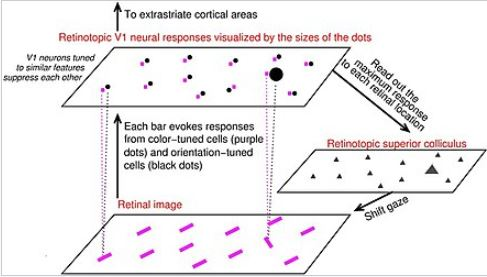

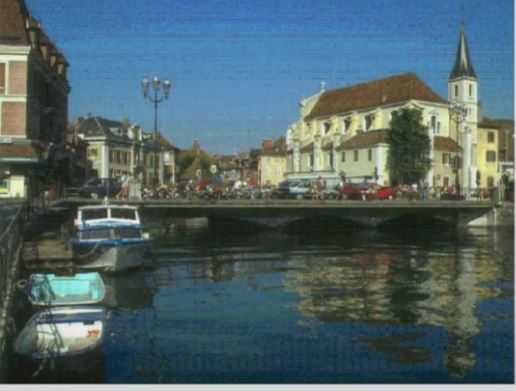

General applications for saliency maps:

* **Compression of images and videos:** The human eye focuses only on a small region
of interest in the frame. As a result, rather than compressing the entire frame with uniform quality, using a salience map reduces the final size of the video while maintaining the same visual perception.

* **Image and video quality evaluation:** The primary goal of an image or video quality metric is to have a high correlation with user opinions. Differences in salient regions are prioritized and thus contribute more to the overall quality score.


* **Object detection, segmentation, and recognition:** Rather than applying a computationally complex algorithm to the entire image, we can apply it to the most prominent regions of an image that are most likely to contain an object.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as T
import requests

from torchsummary  import summary
from PIL import Image
import requests


we don’t need to find gradients with respect to the parameters of the network, therefore `param.requires_grad = False`

`True`  means all layers have the parameters modified during training

In [3]:
# for image classification : using a pretrained VGG-19 ConvNet for image classification

model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False   #  freezing -- no changes happen to its parameters



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 98.3MB/s]


Downloading and opening the image of interest to extract the saliency map


In [4]:
def download(url,fname):
    response = requests.get(url)
    with open(fname,"wb") as f:
        f.write(response.content)


In [5]:

img = Image.open(requests.get('https://drive.google.com/uc?id=1JjYlGSt7cXhG7MCa11wUnHpwdIBWK2_q', stream=True).raw)


In [6]:
url = 'https://t3.ftcdn.net/jpg/02/53/35/52/240_F_253355221_JcdXHHyCeVYiOqt3dRoQGlMS6Z4x9ZGI.jpg'
img = Image.open(requests.get(url, stream=True).raw)

In [7]:
# preprocessing: 1- resize to  224X224 for vgg  2- convert image to tensor 3-  normalize the tensor by  μ nad σ of the images of the ImageNet dataset

# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)


# displaying the image

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))
    plt.axis('off')

In relation to the input image, the saliency map is the gradient of the highest score value. However, keep in mind that the input image has three channels: R, G, and B. We take the maximum magnitude across all color channels to derive a single class saliency value for each `pixel(i,j)`.

In [8]:
# preprocess the image
X = preprocess(img)

# we would run the model in evaluation mode
model.eval()
# we need to find the gradient with respect to the input image, so, calling requires_grad_ on it
X.requires_grad_()
#forward pass through the model to get the scores(VGG-19 doesn't perform softmax at the end) we also don't need softmax, we need scores
scores = model(X)


In [9]:
# Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax()
score_max       = scores[0,score_max_index]

In [10]:

# backward pass to calculates the gradient of score_max with respect to nodes in the computation graph
score_max.backward()


Now, the gradient with respect to the input image would be saliency. However, keep in mind that the input image has 3 channels: R, G, and B. We take the maximum magnitude across all color channels to derive a single class saliency value for each pixel.

In [11]:
Rimg = T.functional.resize(img, size=[224,224])


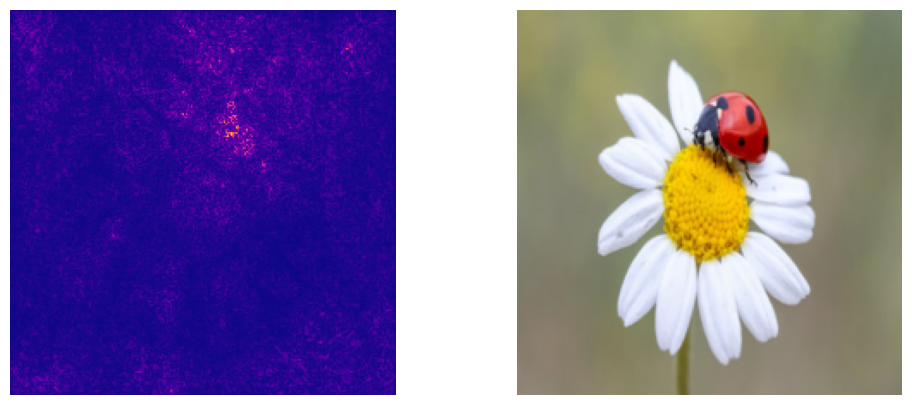

In [15]:

saliency, _ = torch.max(X.grad.data.abs(),dim=1)

#plot the saliency map as a heatmap
fig,ax = plt.subplots(1,2, figsize = (12,5))
ax[0].imshow(saliency[0], cmap=plt.cm.plasma)
ax[0].set_axis_off()


ax[1].imshow(Rimg)
ax[1].set_axis_off()

plt.show()



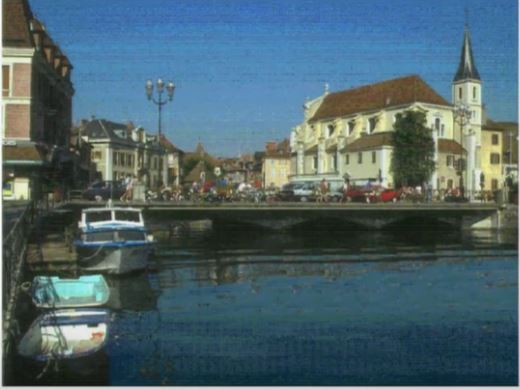

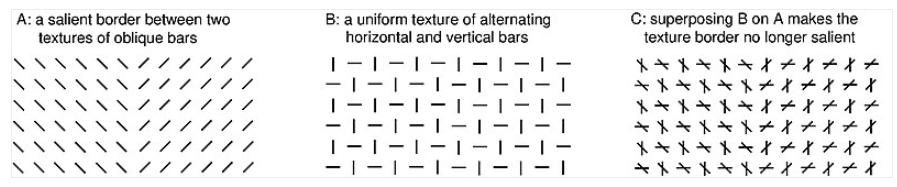

could we use it in adversarial attack? make a perturbation less salient and therfore difficult to detect, perhaps.

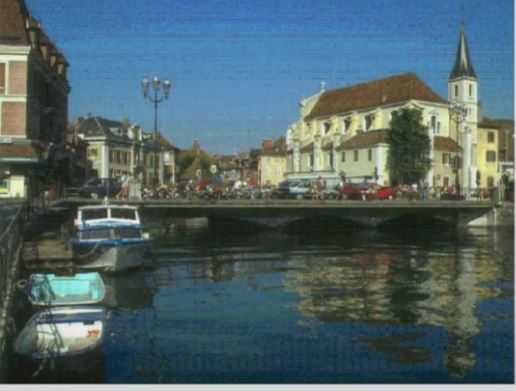